In [1]:
import numpy as np
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Use TensorFlow's Keras API
# Example of using Keras API directly from TensorFlow
# keras_layers = tf.keras.layers
# keras_utils = tf.keras.utils
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

2023-11-21 10:01:45.821532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-21 10:01:46.474784: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/zhangze6/Research/cudnn-11.2-linux-x64-v8.1.1.33/cuda/lib64:/usr/local/cuda-11.2/lib64
2023-11-21 10:01:46.474827: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/zhangze6/Research/cudnn-11.2-li

2.11.0
2.11.0


In [2]:
images = np.load("../images_CNN.npy")
print(images.shape)
labels = np.load("../labels_CNN.npy")
print(labels.shape)

(1728, 256, 256)
(1728,)


In [3]:
unique_labels, counts = np.unique(labels, return_counts=True)
unique_labels

array(['Cas', 'Gem', 'Ori', 'Per', 'ST', 'UM'], dtype='<U3')

In [4]:
label_mapping = {'Cas': 0, 'Gem': 1, 'Ori': 2, 'Per': 3, 'ST': 4, 'UM': 5}
labels_mapped = [label_mapping[label] for label in labels]
labels_encoded = to_categorical(labels_mapped, num_classes=6)
labels_encoded

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [5]:
images = images/255
images.max()

1.0

In [6]:
x_train, x_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded)
print(x_train.shape)
print(y_train.shape)

(1382, 256, 256)
(1382, 6)


In [7]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def residual_block(x, filters, kernel_size=3, stride=1):
    # Shortcut
    shortcut = x

    # First convolution layer
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolution layer
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding="same")(x)
    x = BatchNormalization()(x)

    # Adding the shortcut to the output of the convolution block
    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

def simple_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=7, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding="same")(x)

    # Residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    # Global Average Pooling and Output layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (256, 256, 1)  # images size
num_classes = 6  # Number of classes 

Resmodel = simple_resnet(input_shape, num_classes)
Resmodel.summary()

Resmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  3200        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

2023-11-21 10:11:43.170341: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-21 10:11:43.174830: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-21 10:11:43.175191: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-21 10:11:43.175742: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [10]:
Resmodel.fit(x_train, y_train, epochs = 20, batch_size=32)

Epoch 1/20
44/44 [==============================] - 1s 21ms/step - loss: 1.2336 - accuracy: 0.5217
Epoch 2/20
44/44 [==============================] - 1s 21ms/step - loss: 1.2041 - accuracy: 0.5391
Epoch 3/20
44/44 [==============================] - 1s 21ms/step - loss: 1.1710 - accuracy: 0.5449
Epoch 4/20
44/44 [==============================] - 1s 21ms/step - loss: 1.1304 - accuracy: 0.5658
Epoch 5/20
44/44 [==============================] - 1s 21ms/step - loss: 1.1011 - accuracy: 0.5745
Epoch 6/20
44/44 [==============================] - 1s 22ms/step - loss: 1.0948 - accuracy: 0.5847
Epoch 7/20
44/44 [==============================] - 1s 21ms/step - loss: 1.0658 - accuracy: 0.6042
Epoch 8/20
44/44 [==============================] - 1s 21ms/step - loss: 1.0559 - accuracy: 0.6027
Epoch 9/20
44/44 [==============================] - 1s 21ms/step - loss: 1.0399 - accuracy: 0.6158
Epoch 10/20
44/44 [==============================] - 1s 21ms/step - loss: 1.0224 - accuracy: 0.6042
Epoch 11/

11/11 [==============================] - 0s 7ms/step


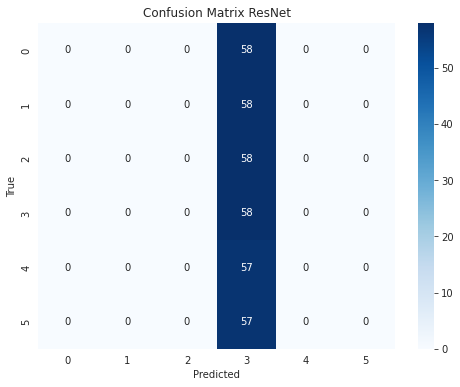

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        58
           1       0.00      0.00      0.00        58
           2       0.00      0.00      0.00        58
           3       0.17      1.00      0.29        58
           4       0.00      0.00      0.00        57
           5       0.00      0.00      0.00        57

    accuracy                           0.17       346
   macro avg       0.03      0.17      0.05       346
weighted avg       0.03      0.17      0.05       346


/home/zhangze6/anaconda3/envs/neuralbody/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zhangze6/anaconda3/envs/neuralbody/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zhangze6/anaconda3/envs/neuralbody/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

In [11]:
predicted_res_prob = Resmodel.predict(x_test)
predicted_res_labels = np.argmax(predicted_res_prob, axis=1)

cmres = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=predicted_res_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cmres, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4 ,5], yticklabels=[0, 1, 2, 3, 4 ,5])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix ResNet')
plt.show()

print(classification_report(y_true=np.argmax(y_test, axis=1), y_pred=predicted_res_labels))